# **Visual Question Answering**

**Paper links:**

1. [VQA: Visual Question Answering](https://arxiv.org/pdf/1505.00468v6.pdf)
2. [Show, Ask, Attend, and Answer:
A Strong Baseline For Visual Question Answering](https://arxiv.org/pdf/1704.03162.pdf)

**What is VQA?**

Given an input image and a natural-language question about the image, the task is to provide a natural-language answer as output. 

**Applications**-
1. Interact with, organize, and navigate visual data
2. Leverage multi-modal information on the web
3. Aid visually-impaired users
4. Summarize visual data for analysis


<img src="./images_notebook/apps.png" width="800" />


Examples Dataset Questions and Images

<img src="./images_notebook/ex_dataset.png" width="800" />

###**Import Libraries**

In [ ]:
#import Libraries
import numpy as np
from keras.utils.np_utils import to_categorical
import json
import h5py
import os
import matplotlib.pyplot as plt

##VQA 1.0 Dataset 
https://visualqa.org/vqa_v1_download.html

VQA is a dataset containing open-ended questions about images. These questions require an understanding of vision, language and commonsense knowledge to answer.

265,016 images (COCO and abstract scenes)
At least 3 questions (5.4 questions on average) per image
10 ground truth answers per question

In total | > 0.25 million images | >1.26 million questions | nearly 25 millions answers


Example Images

<img src="./images_notebook/ex_dataset2.png" width="800" />

The following block of code can be used to download the required dataset to explore the dataset, EDA.
But, to run the model, it is not needed. We have pre-processed files for that.

In [ ]:
#Download Data

#Images
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip

#Questions
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Train_mscoco.zip
!unzip Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Val_mscoco.zip
!unzip Questions_Val_mscoco.zip

#Answers
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Train_mscoco.zip
!unzip Annotations_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Val_mscoco.zip
!unzip Annotations_Val_mscoco.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000007355.jpg  
 extracting: val2014/COCO_val2014_000000281929.jpg  
 extracting: val2014/COCO_val2014_000000118546.jpg  
 extracting: val2014/COCO_val2014_000000533678.jpg  
 extracting: val2014/COCO_val2014_000000343821.jpg  
 extracting: val2014/COCO_val2014_000000447279.jpg  
 extracting: val2014/COCO_val2014_000000255071.jpg  
 extracting: val2014/COCO_val2014_000000187348.jpg  
 extracting: val2014/COCO_val2014_000000131494.jpg  
 extracting: val2014/COCO_val2014_000000258132.jpg  
 extracting: val2014/COCO_val2014_000000523974.jpg  
 extracting: val2014/COCO_val2014_000000161161.jpg  
 extracting: val2014/COCO_val2014_000000408248.jpg  
 extracting: val2014/COCO_val2014_000000454642.jpg  
 extracting: val2014/COCO_val2014_000000248231.jpg  
 extracting: val2014/COCO_val2014_000000434858.jpg  
 extracting: val2014/COCO_val2014_000000549943.jpg  
 extracting: val2014/COCO_val2014_000000302608.j

KeyboardInterrupt: ignored

**EDA** of dataset question words

<img src="./images_notebook/eda_dataset.png" width="1000" />

Figure: Distribution of questions by their first four words for a random sample of 60K questions for real images (left) and all questions
for abstract scenes (right). 

you can check about the VQA dataset Visulaization here
https://visualqa.org/visualize/

  **Answers Analysis**
- 38% of the answers are binary 'yes' and 'no'
- 99% of the question <= 3 word answers
- 23k unique one word answers

<img src="./images_notebook/eda_dataset2.png" width="900" />

Figure : Distribution of answers per question type for a random sample of 60K questions for real images when subjects provide answers when
given the image

**Evaluation Format**
1. Open Answer
- input = image, question

- accuracy = min(# humans that provided that answer/
3
, 1)

2. Multiple choice
- input = image, question, 18 answer options
- options = {correct, plausible, popular, random} answers

In [ ]:
#Some Stats about Data [Source:]

#didnot do it as it was already there + implementing a paper, so just following steps

**Define Constants**

In [1]:
#define constants
seq_length =    26
embedding_dim = 300 #Glove Embedding

data_img =                  './VQA_Final/data/data_img.h5'
data_prepo =                './VQA_Final/data/data_prepro.h5'
data_prepo_meta =           './VQA_Final/data/data_prepro.json'
embedding_matrix_filename = './VQA_Final/data/ckpts/embeddings_%s.h5'%embedding_dim
glove_path =                './VQA_Final/data/glove.6B.300d.txt'
train_questions_path =      './VQA_Final/data/Questions_Train_mscoco/MultipleChoice_mscoco_train2014_questions.json'
val_annotations_path =      './VQA_Final/data/validation_data/mscoco_val2014_annotations.json'
ckpt_model1_weights_filename = './VQA_Final/data/ckpts/model1_weights.h5'
ckpt_model2_weights_filename = './VQA_Final/data/ckpts/model2_weights.h5'
model1_weights_filename =    './VQA_Final/data/model1_weights.h5'
model2_weights_filename =    './VQA_Final/data/model2_weights.h5'

**Data Processing**

In [ ]:
import numpy as np
from keras.utils.np_utils import to_categorical
import json
import h5py

def right_align(seq,lengths):
    v = np.zeros(np.shape(seq))
    N = np.shape(seq)[1]
    for i in range(np.shape(seq)[0]):
        v[i][N-lengths[i]:N]=seq[i][0:lengths[i]]
    return v

def read_data(data_limit):
    print ("Reading Data...")
    img_data = h5py.File(data_img)
    ques_data = h5py.File(data_prepo)
  
    img_data = np.array(img_data['images_train'])
    img_pos_train = ques_data['img_pos_train'][:data_limit]
    train_img_data = np.array([img_data[_-1,:] for _ in img_pos_train])
    # Normalizing images
    tem = np.sqrt(np.sum(np.multiply(train_img_data, train_img_data), axis=1))
    train_img_data = np.divide(train_img_data, np.transpose(np.tile(tem,(4096,1))))

    #shifting padding to left side
    ques_train = np.array(ques_data['ques_train'])[:data_limit, :]
    ques_length_train = np.array(ques_data['ques_length_train'])[:data_limit]
    ques_train = right_align(ques_train, ques_length_train)

    train_X = [train_img_data, ques_train]
    # NOTE should've consturcted one-hots using exhausitve list of answers, cause some answers may not be in dataset
    # To temporarily rectify this, all those answer indices is set to 1 in validation set
    train_y = to_categorical(ques_data['answers'])[:data_limit, :]

    return train_X, train_y

def get_val_data():
    img_data = h5py.File(data_img)
    ques_data = h5py.File(data_prepo)
    metadata = get_metadata()
    with open(val_annotations_path, 'r') as an_file:
        annotations = json.loads(an_file.read())

    img_data = np.array(img_data['images_test'])
    img_pos_train = ques_data['img_pos_test']
    train_img_data = np.array([img_data[_-1,:] for _ in img_pos_train])
    tem = np.sqrt(np.sum(np.multiply(train_img_data, train_img_data), axis=1))
    train_img_data = np.divide(train_img_data, np.transpose(np.tile(tem,(4096,1))))

    ques_train = np.array(ques_data['ques_test'])
    ques_length_train = np.array(ques_data['ques_length_test'])
    ques_train = right_align(ques_train, ques_length_train)

    # Convert all last index to 0, coz embeddings were made that way :/
    for _ in ques_train:
        if 12602 in _:
            _[_==12602] = 0

    val_X = [train_img_data, ques_train]

    ans_to_ix = {str(ans):int(i) for i,ans in metadata['ix_to_ans'].items()}
    ques_annotations = {}
    for _ in annotations['annotations']:
        idx = ans_to_ix.get(_['multiple_choice_answer'].lower())
        _['multiple_choice_answer_idx'] = 1 if idx in [None, 1000] else idx
        ques_annotations[_['question_id']] = _

    abs_val_y = [ques_annotations[ques_id]['multiple_choice_answer_idx'] for ques_id in ques_data['question_id_test']]
    abs_val_y = to_categorical(np.array(abs_val_y))

    multi_val_y = [list(set([ans_to_ix.get(_['answer'].lower()) for _ in ques_annotations[ques_id]['answers']])) for ques_id in ques_data['question_id_test']]
    for i,_ in enumerate(multi_val_y):
        multi_val_y[i] = [1 if ans in [None, 1000] else ans for ans in _]

    return val_X, abs_val_y, multi_val_y


def get_metadata():
    meta_data = json.load(open(data_prepo_meta, 'r'))
    meta_data['ix_to_word'] = {str(word):int(i) for i,word in meta_data['ix_to_word'].items()}
    return meta_data

def prepare_embeddings(num_words, embedding_dim, metadata):
    if os.path.exists(embedding_matrix_filename):
        with h5py.File(embedding_matrix_filename) as f:
            return np.array(f['embedding_matrix'])

    print ("Embedding Data...")
    with open(train_questions_path, 'r') as qs_file:
        questions = json.loads(qs_file.read())
        texts = [str(_['question']) for _ in questions['questions']]
    
    embeddings_index = {}
    with open(glove_path, 'r') as glove_file:
        for line in glove_file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((num_words, embedding_dim))
    word_index = metadata['ix_to_word']

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
   
    with h5py.File(embedding_matrix_filename, 'w') as f:
        f.create_dataset('embedding_matrix', data=embedding_matrix)

    return embedding_matrix

In [ ]:
#Functions to get model, train, and test(here: validate)

import numpy as np
from keras.models import model_from_json#load_model
from keras.callbacks import ModelCheckpoint
import os
import argparse

def get_model(dropout_rate, model_weights_filename,model_name):
    print ("Creating Model...")
    metadata = get_metadata()
    num_classes = len(metadata['ix_to_ans'].keys())
    num_words = len(metadata['ix_to_word'].keys())
    print("NUMBER OF WORDS:", num_words)
    embedding_matrix = prepare_embeddings(num_words, embedding_dim, metadata)
    if(model_name=='model1'):
      model = vqa_model1(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes)
    else:
      model = vqa_model2(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes)
    if os.path.exists(model_weights_filename):
        print ("Loading Weights...")
        model.load_weights(model_weights_filename)

    return model

def train(model_name,model_weights_filename,ckpt_model_weights_filename):
    dropout_rate = 0.5
    train_X, train_y = read_data(215359)    
    '''print("TRAINX: ")
    print(train_X)
    print("TrainX0: ")
    print(train_X[0])
    print("Train_X_shape",train_X[0].shape)
    print("TRAINY: ")
    print(train_y)
    print("TrainY0: ")
    print(train_y[0])
    print("Train_Y_shape",train_y[0].shape)'''
    
    model = get_model(dropout_rate, model_weights_filename,model_name)
    checkpointer = ModelCheckpoint(filepath=ckpt_model_weights_filename,verbose=1)
    history_model = model.fit(train_X, train_y, epochs=10, batch_size=256, callbacks=[checkpointer], shuffle="batch")
    model.save_weights(model_weights_filename, overwrite=True)
    return history_model

def val(model_name,model_weights_filename):
    val_X, val_y, multi_val_y = get_val_data() 
    model = get_model(0.0, model_weights_filename,model_name)
    print ("Evaluating Accuracy on validation set:")
    metric_vals = model.evaluate(val_X, val_y)
    print ("")
    for metric_name, metric_val in zip(model.metrics_names, metric_vals):
        print (metric_name, " is ", metric_val)

    # Comparing prediction against multiple choice answers
    true_positive = 0
    preds = model.predict(val_X)
    pred_classes = [np.argmax(_) for _ in preds]
    for i, _ in enumerate(pred_classes):
        if _ in multi_val_y[i]:
            true_positive += 1
    print ("true positive rate: ", np.float(true_positive)/len(pred_classes))

##Model 1 (LSTM VGG16)
Paper: [VQA: Visual Question Answering](https://arxiv.org/pdf/1505.00468v6.pdf)

<img src="./images_notebook/model1.png" width="900" />

- Input: Image, Questions
-Output: Answer
- Image Channel: CNN (VGG-16)
- Question Channel: Glove Embedding - LSTM *2 layers
- Output: 1 of 1000 most common answers


In [ ]:
#Code for Model 1

from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Multiply
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import h5py

def vqa_model1(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes):
    #Image_Model
    image_input = Input(shape = (4096,))
    dense_img_out = Dense(1024, input_dim=4096, activation='tanh')(image_input)

    #Language_Model
    lang_input = lang_input = Input(shape = (seq_length,))
    embedding = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=seq_length, trainable=False)(lang_input)
    lstm1= LSTM(units=512, return_sequences=True, input_shape=(seq_length, embedding_dim))(embedding)
    drop1 = Dropout(dropout_rate)(lstm1)
    lstm2 = LSTM(units=512, return_sequences=False)(drop1)
    drop2 = Dropout(dropout_rate)(lstm2)
    dense_lang_out = Dense(1024, activation='tanh')(drop2)

    #Merge
    merge1 = Multiply()([dense_img_out, dense_lang_out])
    m_drop1 = Dropout(dropout_rate)(merge1)
    m_dense1 = Dense(1000, activation='tanh')(m_drop1)
    m_drop2 = Dropout(dropout_rate)(m_dense1)
    m_dense2 = Dense(num_classes, activation='softmax')(m_drop2)
    fc_model = Model(inputs=[image_input,lang_input], outputs=m_dense2)
    
    #Compile
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    print(fc_model.summary())
    return fc_model

In [ ]:
history_model1 = train('model1',model1_weights_filename,ckpt_model1_weights_filename)

Reading Data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Creating Model...
NUMBER OF WORDS: 12602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 300)      3780600     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 26, 512)      1665024     embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 26, 512)      0           lstm_2[0][0]                     
____________________________________________________________________________________________

In [ ]:
val('model1',model1_weights_filename)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Creating Model...
NUMBER OF WORDS: 12602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 26, 300)      3780600     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 26, 512)      1665024     embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 26, 512)      0           lstm_4[0][0]                     
____________________________________________________________________________________________

In [ ]:
def plot_loss_acc(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['accuracy'], 'o-')
    #ax.plot([None] + hist.history['val_accuracy'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title('Training/Validation acc per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-',c='r')
    #ax.plot([None] + hist.history['val_loss'], 'x-',c='g')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train loss', 'Validation loss'], loc = 0)
    ax.set_title('Training/Validation loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()

#plot_loss_acc(history_model1)

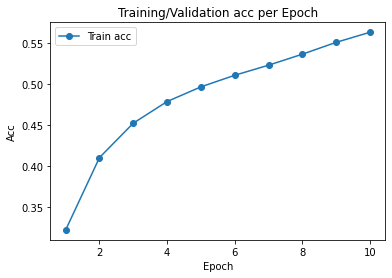

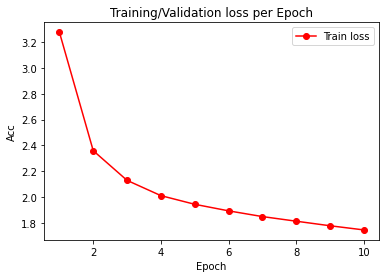

In [ ]:
plot_loss_acc(history_model1)

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LakshaySahni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import keras.backend as K
from keras.layers import Input
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.merge import concatenate, multiply
from keras.layers.core import Dense, Dropout, RepeatVector, Reshape, Activation, Lambda, Flatten

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

#Model2 (LSTM ResNet Attenton)

<img src="./images_notebook/model2.png" width="900" />

- Input: Image, Questions
-Output: Answer
- Image Channel: CNN (ResNet 152 Layer) - We used VGG16
- Question Channel: Glove Embedding- LSTM *2 layers
- Model Training: Stacked Attention over concatenated images features and question vectors
- Output: 1 of 1000 most common answers

**Attention!**

Video:
https://youtu.be/FjpRwVKYJQ8

<img src="./images_notebook/attention_equations.png" width="800" />

<img src="./images_notebook/attention_viz.png" width="800" />

In [ ]:
def vqa_model2(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes):    
    n=2
    vocab_size = num_words
    num_glimpses = 2

    image_input = Input(shape=(4096,))
    image_input2 = Reshape((2,2,1024))(image_input)
    question_input = Input(shape=(seq_length,))

    #Language Model 
    # Learn word embeddings
    question_embedding = Embedding(vocab_size, 300,weights=[embedding_matrix], input_length=seq_length,trainable=False)(question_input)
    question_embedding = Activation('tanh')(question_embedding)
    question_embedding = Dropout(0.5)(question_embedding)
    question_lstm = LSTM(1024)(question_embedding)
    
    # Repeating and tiling question vector to match image input for concatenation
    question_tile = RepeatVector(n*n)(question_lstm)
    question_tile = Reshape((n,n,1024))(question_tile)
    
    # Concatenate1
    concatenated_features1 = concatenate([image_input2, question_tile])
    concatenated_features1 = Dropout(0.5)(concatenated_features1)
    
    # Stacked attention network
    attention_conv1 = Conv2D(512, (1,1))(concatenated_features1)
    attention_relu = Activation('relu')(attention_conv1)
    attention_relu = Dropout(0.5)(attention_relu)
    
    attention_conv2 = Conv2D(num_glimpses, (1,1))(attention_relu)
    attention_maps = Activation('softmax')(attention_conv2)
    
    # Weighted average of image features using attention maps
    image_attention = att(attention_maps, image_input2, num_glimpses, n)
    
    # Concatenation2
    concatenated_features2 = concatenate([image_attention, question_lstm])
    concatenated_features2 = Dropout(0.5)(concatenated_features2)
    
    # First fully connected layer
    fc1 = Dense(1024)(concatenated_features2)
    fc1_relu = Activation('relu')(fc1)
    fc1_relu = Dropout(0.5)(fc1_relu)
    
    # Final fully connected layer
    fc2 = Dense(1000)(fc1_relu)
    fc2_softmax = Activation('softmax')(fc2)
    vqa_model = Model(inputs=[image_input, question_input], outputs=fc2_softmax)
    
    #Compile
    vqa_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
        metrics=['accuracy'])
    print("FC_Model:")
    print(vqa_model.summary())


    return vqa_model

def att(attention_maps, image_features, num_glimpses=2, n=14):
    glimpse_list = []
    for i in range(num_glimpses):
        glimpse_map = Lambda(lambda x: x[:,:,:,i])(attention_maps)                
        glimpse_map = Reshape((n,n,1))(glimpse_map)                               
        glimpse_tile = Lambda(tile)(glimpse_map)                                  
        weighted_features = multiply([image_features, glimpse_tile])              
        weighted_average = AveragePooling2D(pool_size=(n,n))(weighted_features) 
        weighted_average = Flatten()(weighted_average)
        glimpse_list.append(weighted_average)
        
    return concatenate(glimpse_list)

def tile(x):
    return K.tile(x, [1,1,1,1024])

In [ ]:
history_model2 = train('model2',model2_weights_filename,ckpt_model2_weights_filename)

Reading Data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Creating Model...
NUMBER OF WORDS: 12602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


FC_Model:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 300)      3780600     input_3[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 26, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 26, 300)      0           activation_1[0][0]               
__________________________________________________________________________________

In [ ]:
val('model2',model2_weights_filename)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Creating Model...
NUMBER OF WORDS: 12602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


FC_Model:
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 26, 300)      3780600     input_9[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 26, 300)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 26, 300)      0           activation_6[0][0]               
__________________________________________________________________________________

In [ ]:
plot_loss_acc(history_model2)

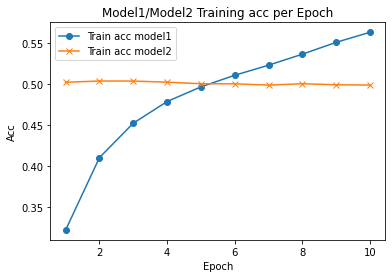

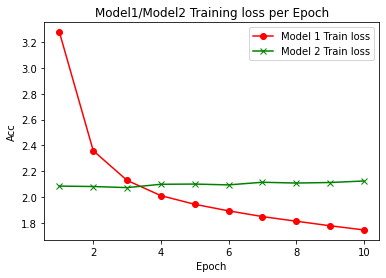

In [ ]:
def plot_loss_acc(hist1,hist2):
    f, ax = plt.subplots()
    ax.plot([None] + hist1.history['accuracy'], 'o-')
    ax.plot([None] + hist2.history['accuracy'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train acc model1', 'Train acc model2'], loc = 0)
    ax.set_title('Model1/Model2 Training acc per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist1.history['loss'], 'o-',c='r')
    ax.plot([None] + hist2.history['loss'], 'x-',c='g')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Model 1 Train loss', 'Model 2 Train loss'], loc = 0)
    ax.set_title('Model1/Model2 Training loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()

plot_loss_acc(history_model1,history_model2)

#Demo

In [ ]:
def demo_helper(ModelNumber,Image_Key,question):
    key_imgid = {"1":3,"2":100,"3":4732,"4":5415,"5":53415,"6":1215}
    img_id = key_imgid.get(Image_Key)
    if(ModelNumber)==1:
        model_weights_filename=model1_weights_filename
        model_name="model1"
    elif(ModelNumber)==2:
        model_weights_filename=model2_weights_filename
        model_name="model2"
    else:
        print("Stupid, enter only 1 or 2 in model number!")
    return demo(model_weights_filename,model_name,question,img_id)


In [ ]:
#Demo Main
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from time import sleep
import pickle

def demo(model_weights_filename,model_name,question,img_id):

    model = get_model(0.0, model_weights_filename,model_name)

    img_data = h5py.File(data_img)

    def get_ques_vector(question):
        question_vector = []
        seq_length = 26
        word_index = metadata['ix_to_word']
        for word in word_tokenize(question.lower()):
            if word in word_index:
                question_vector.append(word_index[word])
            else:
                question_vector.append(0)
        question_vector = np.array(pad_sequences([question_vector], maxlen=seq_length))[0]
        question_vector = question_vector.reshape((1,seq_length))
        return question_vector

    #question= "how many boys are there?"
    metadata = get_metadata()
    img_vector = img_data['images_train'][img_id]
    img_vector = img_vector.reshape((1,4096))
    question_vector = get_ques_vector(question)
    pred = model.predict([img_vector, question_vector])[0]
    #print("PRED: ",pred)


    top_pred = pred.argsort()[-5:][::-1]
    return top_pred,metadata
    print("")
  #for i in range(5):
    #print(metadata['ix_to_ans'].get(str(top_pred[i])))

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(15,15))
img_count=0
for i in range(2):
  for j in range(3):
    img_count+=1
    img = cv.imread('./drive/My Drive/VQA_Final/Images/'+str(img_count)+'.jpg')
    #plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    axs[i, j].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    axs[i, j].set_title('Image '+str(img_count))

#DEMO with FELLOWSS

In [3]:
ModelNumber = int(input("Enter model to choose(1/2)?: "))
Image_key = input("Choose an Image key? (1-6): ")
Question = input("Question?: ")

top_pred,metadata = demo_helper(ModelNumber,Image_key,Question)
print("")
print("Answers")
for i in range(5):
    print("Preferred Answer No. ",i,". ",metadata['ix_to_ans'].get(str(top_pred[i])))

Enter model to choose(1/2)?: 1
Choose an Image key? (1-6): 1
Question?: what is in the picture?


NameError: name 'demo_helper' is not defined

#References

https://visualqa.org/vqa_v1_download.html

https://www.youtube.com/watch?v=FjpRwVKYJQ8&feature=youtu.be

https://www.youtube.com/watch?v=ElZADFTer4I

https://github.com/Cyanogenoid/pytorch-vqa

https://github.com/anantzoid/VQA-Keras-Visual-Question-Answering

##Issues
1. Model 2 - Used VGG16 instead of ResNEt - creating issues - issue of Time and Disk Space
2. Need to show the visualisation of the attention maps - for better interpretability
